## Analyzing album and track sales with SQL

In this notebook we'll be answering questions about the sales of albums, tracks and employee performance. The data is based on a modified version of a database called Chinook from the Dataquest SQL specialization course.

The Chinook database contains fictional information about artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables, with the following schema diagram:

![](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

Before answering questions about the sales records, lets take a quick look at the database and samples of information included in the customer, employee and album tables. 

First, lets verify the table names in the database:

In [2]:
%%sql
SELECT
    name
FROM sqlite_master
WHERE type IN ("table","view");

Done.


name
album
artist
customer
employee
genre
invoice
invoice_line
media_type
playlist
playlist_track


Now, let's examine the first few rows of the album, customer and employee tables.

In [3]:
%%sql
SELECT *
FROM album
LIMIT 5

Done.


album_id,title,artist_id
1,For Those About To Rock We Salute You,1
2,Balls to the Wall,2
3,Restless and Wild,2
4,Let There Be Rock,1
5,Big Ones,3


In [4]:
%%sql
SELECT *
FROM customer
LIMIT 5

Done.


customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
1,Luís,Gonçalves,Embraer - Empresa Brasileira de Aeronáutica S.A.,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,+55 (12) 3923-5555,+55 (12) 3923-5566,luisg@embraer.com.br,3
2,Leonie,Köhler,None,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,+49 0711 2842222,None,leonekohler@surfeu.de,5
3,François,Tremblay,None,1498 rue Bélanger,Montréal,QC,Canada,H2G 1A7,+1 (514) 721-4711,None,ftremblay@gmail.com,3
4,Bjørn,Hansen,None,Ullevålsveien 14,Oslo,None,Norway,0171,+47 22 44 22 22,None,bjorn.hansen@yahoo.no,4
5,František,Wichterlová,JetBrains s.r.o.,Klanova 9/506,Prague,None,Czech Republic,14700,+420 2 4172 5555,+420 2 4172 5555,frantisekw@jetbrains.com,4


In [5]:
%%sql
SELECT *
FROM employee
LIMIT 5

Done.


employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
1,Adams,Andrew,General Manager,None,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
2,Edwards,Nancy,Sales Manager,1,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


The schema above shows the primary and foreign key relationships between the tables, which we will use to join data in our queries. For example, the **customer** table, the primary key is *customer_id*, which relates to the foreign key *customer_id* in the **invoice** table.

---

### Scenario 1

The Chinook record store has just signed a deal with a new record label. The record label has four albums by artists that don't have any tracks in the store right now. All we are provided with is the artist name and the genre of music they produce. The record label specializes in artists from the USA and would like to advertise there. 

We need to find which genres sell best in the USA so that we can make a recommendation for the three artists whose albums Chinook should purchase for the store.

In [6]:
# Query for genre and number of tracks sold in the USA
# return both absolute numbers and percentages

'''
First we create a view that stores the total number of tracks, 
which we can then call on to calculate percentages.

Then we count the number of tracks purchased for each genre that 
were purchased in the USA only.
'''

'\nFirst we create a view that stores the total number of tracks, \nwhich we can then call on to calculate percentages.\n\nThen we count the number of tracks purchased for each genre that \nwere purchased in the USA only.\n'

Validate the query to count the total number of tracks

In [7]:
%%sql
SELECT COUNT(t.track_id) total_count
                       FROM invoice i
                            INNER JOIN invoice_line il 
                            ON il.invoice_id = i.invoice_id
                            
                            LEFT JOIN track t 
                            ON il.track_id = t.track_id 
    
                            INNER JOIN genre g 
                            ON t.genre_id = g.genre_id 
                      WHERE i.billing_country = "USA"

Done.


total_count
1051


Now let's combine the two to get a list of track sales by genre

In [8]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

query = '''
WITH total_tracks as (
    SELECT 
        COUNT(t.track_id) as total_tracks 
    FROM track as t
        INNER JOIN genre as g on g.genre_id = t.genre_id
        LEFT JOIN invoice_line as il on il.track_id = t.track_id
        INNER JOIN invoice as i on i.invoice_id = il.invoice_id
        INNER JOIN customer as c on c.customer_id = i.customer_id
    WHERE c.country = 'USA')

SELECT 
    g.name,
    COUNT(il.quantity) as num_tracks,
    ROUND(COUNT(il.quantity) *100/ (SELECT total_tracks from total_tracks),1) AS pct_sales
    FROM track as t
        INNER JOIN genre as g on g.genre_id = t.genre_id
        LEFT JOIN invoice_line as il on il.track_id = t.track_id
        INNER JOIN invoice as i on i.invoice_id = il.invoice_id
        INNER JOIN customer as c on c.customer_id = i.customer_id
    WHERE c.country = 'USA'
    GROUP BY g.name
    ORDER BY num_tracks DESC
'''

conn = sqlite3.connect("chinook.db")
df = pd.read_sql_query(query, conn)
df

,name,num_tracks,pct_sales
0,Rock,561,53.0
1,Alternative & Punk,130,12.0
2,Metal,124,11.0
3,R&B/Soul,53,5.0
4,Blues,36,3.0
5,Alternative,35,3.0
6,Latin,22,2.0
7,Pop,22,2.0
8,Hip Hop/Rap,20,1.0
9,Jazz,14,1.0


The top selling genres in the USA are **Rock**, **Alternative**, and **Metal**, accounting for 76\% of total sales. For the record label selling albums in the Hip-Hop, Punk, Pop and Blues genres, we would be best suited to purchase the albums from Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop). Note that there is only a difference of two tracks sold between Hip-Hop and Pop albums, so the sales should be monitored to determine if this narrow popularity gap remains - if not, we could switch to purchasing the album from Regal (Hip-Hop).

---

### Scenario 2

Each customer for the Chinook music store gets assigned to a sales associate within the company when they make their first purchase. We want to analyze the purchases of customers belonging to determine the relative sales performances of all associates.

Let's write a query to find the total dollar amount of sales assigned to each associate within the company.

In [9]:
%%sql
SELECT e.first_name || ' ' || e.last_name AS employee_name,
    e.hire_date AS hire_date,
    e.title AS job_title
FROM employee as e

Done.


employee_name,hire_date,job_title
Andrew Adams,2016-08-14 00:00:00,General Manager
Nancy Edwards,2016-05-01 00:00:00,Sales Manager
Jane Peacock,2017-04-01 00:00:00,Sales Support Agent
Margaret Park,2017-05-03 00:00:00,Sales Support Agent
Steve Johnson,2017-10-17 00:00:00,Sales Support Agent
Michael Mitchell,2016-10-17 00:00:00,IT Manager
Robert King,2017-01-02 00:00:00,IT Staff
Laura Callahan,2017-03-04 00:00:00,IT Staff


The Chinook music company has eight employees, but only three sales support agents so all of the sales are concentrated on those employees. Let's extract the total sales, number of customers and hire date for each employee. We will then compute relative metrics such as relative sales, sales per customer and manually compute the sales per month of employment.

In [10]:
query = '''
WITH company_sales AS (
    SELECT sum(i.total) AS company_sales
    FROM invoice as i),
total_customers AS (
    SELECT count(c.customer_id) AS total_customers
    FROM employee as e
    INNER JOIN customer as c on c.support_rep_id = e.employee_id
    INNER JOIN invoice as i on i.customer_id = c.customer_id)

SELECT 
    e.first_name || ' ' || e.last_name AS employee_name,
    sum(i.total) AS total_sales,
    ROUND(sum(i.total)*100/(SELECT company_sales FROM company_sales),1) AS pct_sales,
    count(c.customer_id) AS num_customers,
    ROUND(count(c.customer_id)*100/(SELECT total_customers FROM total_customers),1) AS pct_customers,
    e.hire_date AS hire_date,
    e.title AS job_title
FROM employee as e
INNER JOIN customer as c on c.support_rep_id = e.employee_id
INNER JOIN invoice as i on i.customer_id = c.customer_id
GROUP BY employee_name
ORDER BY total_sales DESC
LIMIT 10
'''

conn = sqlite3.connect("chinook.db")
df_employee_sales = pd.read_sql_query(query, conn)
#df_employee_sales
# compute days employed assuming analysis date is the end of the year 2017
import datetime as dt
yr_end_date = dt.date(2017, 12, 31)

# define helper function to compute difference in days
def days_between(d1, d2):
    d1 = dt.strptime(d1, "%Y-%m-%d")
    d2 = dt.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

# convert hire date to datetime object
df_employee_sales['hire_date']= pd.to_datetime(df_employee_sales['hire_date'])
df_employee_sales['days_employed'] = (yr_end_date - df_employee_sales['hire_date']).dt.days
df_employee_sales['sales_per_30_days'] = df_employee_sales['total_sales']*30/df_employee_sales['days_employed']
# display final dataframe
df_employee_sales

,employee_name,total_sales,pct_sales,num_customers,pct_customers,hire_date,job_title,days_employed,sales_per_30_days
0,Jane Peacock,1731.51,36.8,212,34.0,2017-04-01,Sales Support Agent,274,189.581387
1,Margaret Park,1584.00,33.6,214,34.0,2017-05-03,Sales Support Agent,242,196.363636
2,Steve Johnson,1393.92,29.6,188,30.0,2017-10-17,Sales Support Agent,75,557.568000


Let's create a few summary figures to illustrate how the sales are distributed amoung sales reps and how their sales compare to length of employment.

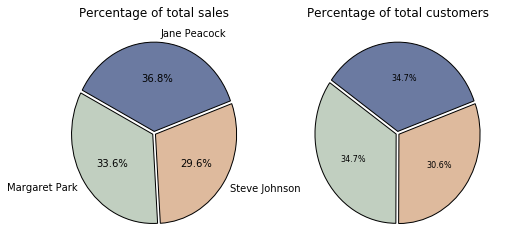

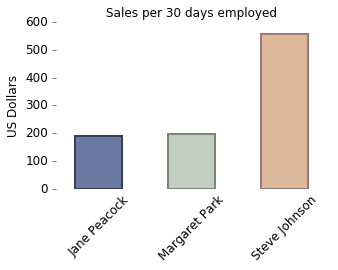

In [11]:
fig, axs = plt.subplots(1, 2, figsize = (8,4), sharex=False)

# define color scheme and set optional explode separation between pie slices
colors = ['#6B7AA1', '#C1CFC0', '#DEBA9D']
edgecolors = ['#383E56', '#798777', '#9E7777']

explode = (0.02, 0.02, 0.02)
employee_names = list(df_employee_sales.employee_name)

df_employee_sales['pct_sales'].plot(kind = 'pie', ax = axs[0], autopct = '%1.1f%%', 
                                    startangle = 20, fontsize = 10, colors = colors,
                                    explode = explode, labels = employee_names, y = '%',
                                   title = 'Percentage of total sales')
df_employee_sales['pct_customers'].plot(kind = 'pie', ax = axs[1], autopct = '%1.1f%%', 
                                        startangle = 20, fontsize = 8, colors = colors,
                                        explode = explode, labels = ['', '', ''],
                                       title = 'Percentage of total customers')
axs[0].set_ylabel('')
axs[1].set_ylabel('')

# plot sales versus employment length
f = plt.figure(figsize = (5,3))
ax = f.add_subplot(1,1,1)
df_employee_sales.plot.bar(ax = ax, x='employee_name', y='sales_per_30_days', 
                           rot=0, title='Sales per 30 days employed', 
                           fontsize = 12, color = colors , linewidth = 2,
                           width = 0.5, edgecolor = edgecolors, legend=False)

# set axes labels
ax.set_ylabel('US Dollars', fontsize=12)
ax.set_xlabel('')

# set x labels for bottom subplot
labels = list(df_employee_sales.employee_name)
ax.set_xticklabels(labels = labels, 
                   fontsize=12, 
                   rotation=45)
# configure axes to hide tick marks and spines
ax.tick_params(bottom = False, top = False, right = False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

plt.show()

From the above table and figures we can see that total sales are closely related to number of customers. Jane Peacock has the highest total sales at \$1731.51 from 212 customers, which represents 36.8\% of the total sales and approximately 35\% of the customers. However, Jane has also been at the company the longest. If we consider sales_per_30_days, we see that Jane has the lowest sales per 30 days employed (\$190 per 30 days), while Steve, who has only been employed for 75 days, has been more proficient with nearly \$560 per 30 days employed. 

---

### Scenario 3

Now we would like to examine the sales data for customers from each different country. In particular, we are interested in:

1. total number of customers
2. total value of sales
3. average value of sales per customer
4. average order value

Notes: We will use the country associated with the customers profile rather than the country on the invoice. Moreover, there are some countries with one customer and these will be grouped as 'Other' in the analysis and displayed at the bottom of the query results.

In [12]:
query = '''
    WITH total_sales as (
                        SELECT 
                            c.country as country,
                            sum(i.total) as total_sales
                        FROM customer as c
                        INNER JOIN invoice as i on i.customer_id = c.customer_id
                        GROUP BY c.country
                        ),
    total_purchases as (
                        SELECT 
                            c.country,
                            count(i.invoice_id) as orders
                        FROM customer as c
                        INNER JOIN invoice as i on i.customer_id = c.customer_id
                        GROUP BY c.country
                        ),
    sales_country_categories as (
                        SELECT 
                            c.country, 
                            (SELECT
                                 (CASE
                                WHEN count(c.customer_id) < 2 THEN 'Other'
                                ELSE c.country
                            END)) as country_cat,
                            count(c.customer_id) as customers,
                            tp.orders as orders,
                            ROUND(ts.total_sales,1) as total_sales 
                        FROM customer as c
                        INNER JOIN total_sales as ts on ts.country = c.country
                        INNER JOIN total_purchases as tp on tp.country = c.country
                        GROUP BY c.country
                        ORDER BY customers DESC
                        ),
    purchases_summary as (
                        SELECT
                            country_cat as country,
                            sum(customers) as customers,
                            sum(orders) as orders,
                            sum(total_sales) as total_sales,
                            ROUND(sum(total_sales)/sum(customers),1) as avg_sales_customer,
                            ROUND(sum(total_sales)/sum(orders),1) as avg_sales_order
                        FROM sales_country_categories
                        GROUP BY country_cat
                        ORDER BY customers DESC
                        )

SELECT
    country,
    customers,
    orders,
    total_sales,
    avg_sales_customer,
    avg_sales_order
FROM
    (
    SELECT
        ps.*,
        CASE
            WHEN ps.country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM purchases_summary as ps
   )
ORDER BY sort ASC
'''
conn = sqlite3.connect("chinook.db")
df_sales_countries = pd.read_sql_query(query, conn)
df_sales_countries

,country,customers,orders,total_sales,avg_sales_customer,avg_sales_order
0,USA,13,131,1040.5,80.0,7.9
1,Canada,8,76,535.6,67.0,7.0
2,Brazil,5,61,427.7,85.5,7.0
3,France,5,50,389.1,77.8,7.8
4,Germany,4,41,334.6,83.7,8.2
5,United Kingdom,3,28,245.5,81.8,8.8
6,Czech Republic,2,30,273.2,136.6,9.1
7,India,2,21,183.1,91.5,8.7
8,Portugal,2,29,185.1,92.5,6.4
9,Other,15,147,1094.8,73.0,7.4


Let's plot the total sales and average sale per customer for each country

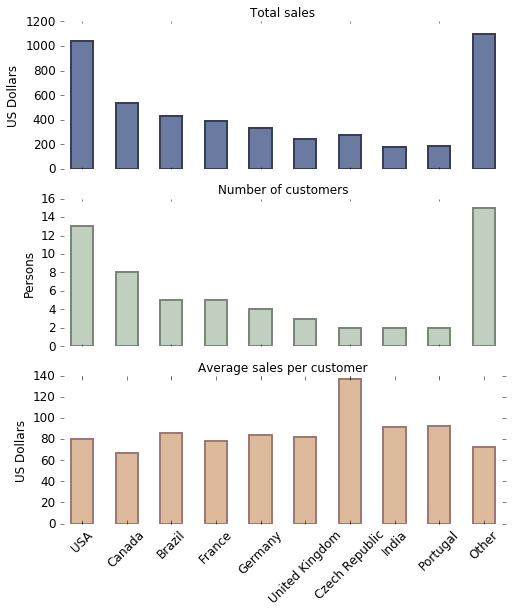

In [13]:
fig, axs = plt.subplots(3, 1, figsize = (8,9), sharex=True)
# add series from sales_countries dataframe
df_sales_countries.plot.bar(ax = axs[0], x = 'country', y = 'total_sales', 
                            rot = 0, title = 'Total sales', fontsize = 12,
                            color = '#6B7AA1', edgecolor = '#383E56', 
                            linewidth = 2, legend=False)
df_sales_countries.plot.bar(ax = axs[1], x = 'country', y = 'customers', 
                            rot = 0, title = 'Number of customers', fontsize = 12,
                            color = '#C1CFC0', edgecolor = '#798777', 
                            linewidth = 2, legend=False)
df_sales_countries.plot.bar(ax = axs[2], x='country', y='avg_sales_customer', 
                            rot=0, title='Average sales per customer', 
                            fontsize = 12, color = '#DEBA9D', linewidth = 2,
                            edgecolor = '#9E7777', legend=False)

# set axes labels
axs[0].set_ylabel('US Dollars', fontsize=12)
axs[1].set_ylabel('Persons', fontsize=12)
axs[2].set_ylabel('US Dollars', fontsize=12)
axs[2].set_xlabel('')

# set x labels for bottom subplot
labels = list(df_sales_countries.country)
axs[2].set_xticklabels(labels = labels, 
                   fontsize=12, 
                   rotation=45)
# configure axes to hide tick marks and spines
axs[0].tick_params(bottom = False, top = False, right = False)
axs[1].tick_params(bottom = False, top = False, right = False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
axs[1].spines["bottom"].set_visible(False)
axs[2].spines["top"].set_visible(False)
axs[2].spines["right"].set_visible(False)
axs[2].spines["left"].set_visible(False)
axs[2].spines["bottom"].set_visible(False)


The total sales for is strongly correlated with number of customers, with both being largest from the USA. The total sales from all 'Other' countries, with only one customer is approximately equal to the USA sales, and the average purchase per customer is nearly equivalent. Interestingly, the Czech Republic has the highest average sale per customer at nearly \$140 USD, and perhaps there may be different marketing strategies used there that are particularly effective. Aside from the Czech Republic, the average sale per customer is relatively similar, and ranges from 65 to 85 US dollars.